# The purpose of this notebook is to familiarize yourself with some of the helpful functions in the SnI (Susceptible n-Infected) class



In [1]:
#allows plots in notebook
%matplotlib inline
#sets notebook figures to high quality svg
%config InlineBackend.figure_format = 'svg'

import pandas as pd
import numpy as np
from src.ModelFrameworks import SnI
import matplotlib.pyplot as plt

#ignore warnings to avoid flooding notebook output
import warnings
warnings.filterwarnings('ignore')

## Data Import
The SnI class must be provided with a dataframe indexed correctly with the correct data. Bellow, we will import some an example

In [2]:
df = pd.read_csv('data/testdat.csv')
df = df.set_index('organism')
df

,time,abundance,uncertainty
organism,,,
virus,0.0,10981000.0,656690.00
virus,0.2,12959000.0,2987300.00
virus,0.3,13273000.0,3480600.00
virus,0.5,17914000.0,3981250.00
virus,0.7,15899000.0,4815700.00
virus,0.9,13881000.0,3985500.00
virus,0.9,15545000.0,3491900.00
virus,1.0,14527000.0,5474350.00
virus,1.2,12516000.0,6314200.00


As you can see, data is indexted by the organsim and identified as either virus or host. The other pieces of data included are time, the abundance at that time, and the uncertainty. Now that we have our data, lets initialize an instance of the SnI class

In [3]:
#initialize model framework
modframe = SnI(df,Infection_states=0)
modframe

Number of Infection States = 0
Parameters:
	mu = 1e-06
	phi = 1e-08
	beta = 25

Notice that we need to specify the number of infection states. SnI is smart enought to know what parameters are needed depending on the infection state and if you do not provide parameters it will assign default values. We can use the plot() function to visualize the fit

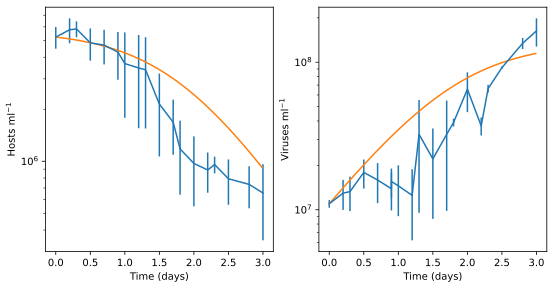

In [4]:
f,ax=modframe.plot()

Not a bad fits for defaults! But lets see what it looks like when we change the number of infection states by accessing the attribute Istates

Number of Infection States = 1
Parameters:
	mu = 1e-06
	phi = 1e-08
	beta = 25
	lam = 1


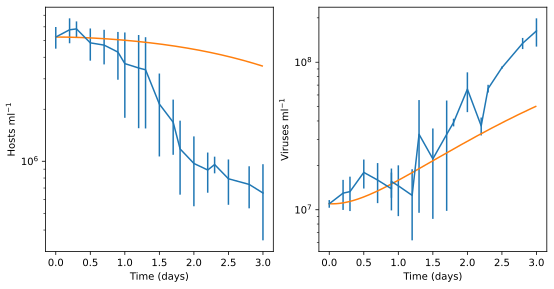

In [5]:
modframe.Istates=1
print(modframe)
f,ax=modframe.plot()

As you can see, *lam* is now included in the parameters with the default value. What you can also see is that the initial parameters are so egregious, euler integration produced negative numbers (which we define as a failure). Luckily, we can search for some initial values using a latin hypercube sampling scheme. Using search_inits(), we will take 100,000 samples using the priors we provide for each parameter, which are assumed to be a normal distribution with the lower bound > 0. Priors are specified by passing a tupple with the mean,standard deviation, and a boolean indicating a tinylog transfromation (please, if there is a actual name for this type of transformation, let me know). The tinylog transformation places the mean at $10^{-\mu}$ and the standard deviation spans log space, making the sampling ideal for very small values (such as $\mu$ or $\phi$).If a parameter is not provided with a prior, all samples will include the default parameters.

Lets search for initial values. Note, this process supports muliple cores!

Sampling with a Latin Hypercube sampling scheme...[DONE]
Starting 100000 processes with 8 cores
count    81662.000000
mean       135.397998
std         88.634905
min         10.172193
25%         86.097510
50%        150.654110
75%        152.825158
max       1566.755248
Name: chi, dtype: float64


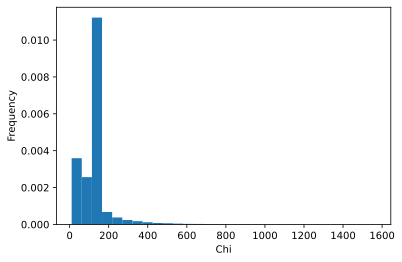

In [6]:
#Remember, search_inits is hardcoded to only sample positive numbers!
mu_prior = (6,3,True) # mean: 10^-6, mean - std: 10^-10, mean + std: 10^-2
phi_prior = (8,4,True)
beta_prior = (30,15,False)# normal distribution, mean = 30, sigma = 15.
lam_prior = (1,1,False)
inits=modframe.search_inits(samples=100000,cpu_cores=8,
                            mu=mu_prior,
                            phi=phi_prior,
                            beta=beta_prior,
                            lam=lam_prior
                           )
#lets plot the chi
a=inits['chi'].plot.hist(bins=30,density=True)
a.set_xlabel('Chi')
print(inits['chi'].describe())

We just ran 100,000 simulations searching for good initials. There are two things you should realize:
1. The inits dataframe had less than 100,000 rows of parameters
2. There are some **very** bad fits ( chi >150), but also some good fits

The reason why we didn't get 100,000 parameter sets is because some would cause the Euler integration to fail. However, that is to be expected. If you are not getting any good fits from the initial parameter search, you likely have to relax your constrains on your priors.

Now that we have some nice priors, lets sub-sample 20 parameters sets. We will restrict this sub sampling to the lower quarter quantile of chis, guaranteeing us to get decent initial parameters to initialize our markov chains. To launch the MCMC analysis, we use the function MCMC and pass our initial values

In [7]:
#Getting 20 draws of inits with good chis!
MCMC_inits = inits[inits['chi'] < inits['chi'].quantile(.25)].sample(20)
print(MCMC_inits)
#Launching 20 markov chains, 10,000 iterations each
#median values are set as new parameters for the modframe
posteriors = modframe.MCMC(chain_inits = MCMC_inits,iterations=10000,cpu_cores=8)
posteriors

                 mu           phi       beta       lam        chi
85851  5.298708e-09  1.001903e-04  34.740704  0.068990  61.601220
44367  2.992391e-10  1.161547e-08  34.603256  2.261801  25.233280
49354  1.878408e-06  4.751178e-06  37.285397  0.159689  40.180860
96336  5.775819e-04  9.853798e-09  43.577891  1.936626  30.624441
5121   6.351341e-07  8.635359e-08  37.475238  1.380306  80.745987
60080  1.276808e-08  7.036473e-09  27.661629  1.971631  47.765972
20168  1.230047e-04  3.187136e-09  41.018234  1.747100  70.048739
40817  2.157921e-05  2.256879e-06  23.254709  0.924294  49.078275
29435  4.306620e-06  1.135183e-08  34.104122  2.920336  24.487423
32920  7.635257e-05  1.055913e-05  29.646576  0.479163  40.357183
51653  2.130126e-03  6.393049e-06  12.247139  0.892413  24.018944
85067  1.111435e-03  1.157383e-08  49.932442  1.756061  36.143083
50300  5.293251e-05  1.087867e-05   8.956267  1.270015  52.713386
64330  1.772569e-09  4.141333e-09  59.700166  2.114681  41.947795
99130  4.9

,mu,phi,beta,lam,chi,adjR2,Iteration,chain#
0,2.405283e-08,9.572224e-07,10.388750,0.595889,18.329803,0.213734,5001.0,0
1,2.347457e-08,9.270133e-07,9.645362,0.559222,20.842269,0.147594,5005.0,0
2,2.715658e-08,9.446483e-07,9.818351,0.556697,20.601570,0.158669,5010.0,0
3,2.719125e-08,9.166722e-07,9.171554,0.612000,19.874701,0.137071,5012.0,0
4,2.652859e-08,9.423321e-07,8.677874,0.645744,20.023162,0.112802,5013.0,0
...,...,...,...,...,...,...,...,...
66111,3.297833e-09,5.518591e-08,13.725200,1.423747,10.531144,0.497893,9992.0,19
66112,3.379859e-09,5.429621e-08,12.714366,1.422172,10.450691,0.455515,9994.0,19
66113,3.212423e-09,5.220819e-08,14.121802,1.415140,10.288783,0.514004,9995.0,19
66114,3.343141e-09,5.413137e-08,14.050629,1.359839,10.229640,0.509308,9997.0,19


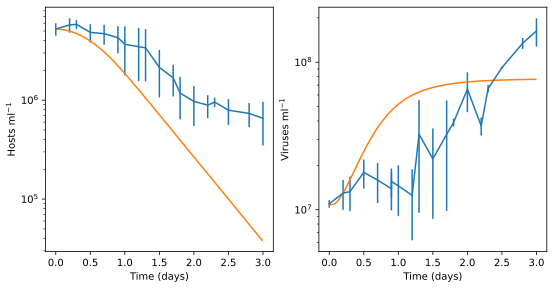

In [8]:
f,ax=modframe.plot()

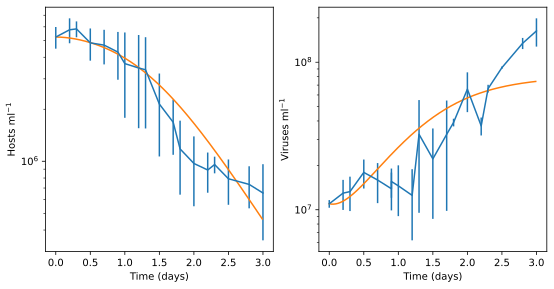

In [9]:
#for plotting purposes, lets grab the lowest chi to show the best fit we got
d=posteriors.loc[posteriors['chi'].idxmin()].to_dict()
f,ax=modframe.plot(**d)

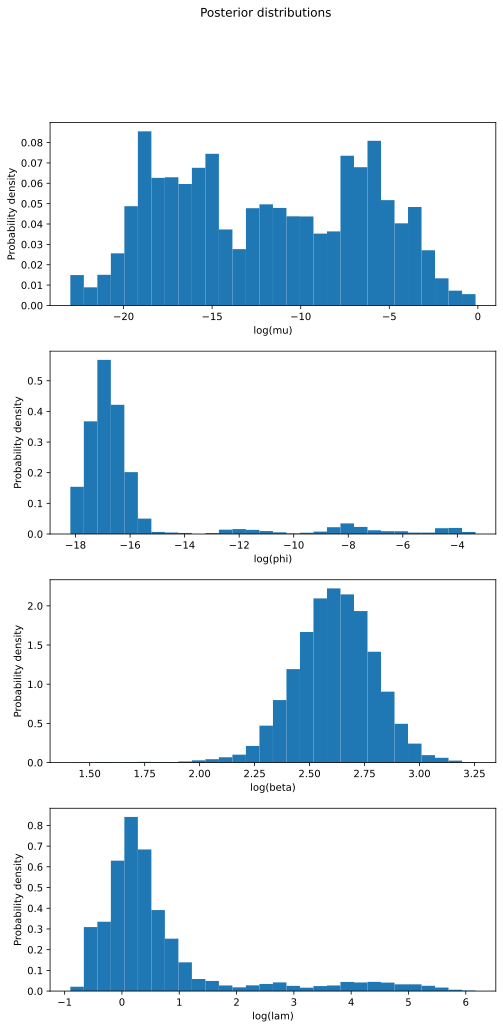

In [10]:
pnames = modframe.get_pnames()
dim = len(pnames)
f,ax = plt.subplots(dim,figsize=[dim*2,dim*4])
ax = ax.flatten()
for (a,p,i) in zip(ax,pnames,range(len(pnames))):
    a.hist(np.log(posteriors[p]),30,density=True)
    a.set_xlabel('log('+p+')')
    a.set_ylabel('Probability density')
f.suptitle('Posterior distributions')
f.subplots_adjust(hspace=0.25,wspace=0.25)    

## Results

Our posterior distribuitons seem to be very large